In [2]:
# set visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
# set the cwd to the root of the repo

import os
# change dir to root of repo
os.chdir('..')

import torch
import yaml
from pathlib import Path
import random
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from nerfstudio.configs import base_config as cfg
from nerfstudio.configs.method_configs import method_configs
from nerfstudio.data.dataparsers.nerfosr_dataparser import NeRFOSR, NeRFOSRDataParserConfig
from nerfstudio.models.reni_neus import RENINeuSModel, RENINeuSModelConfig
from nerfstudio.pipelines.base_pipeline import VanillaDataManager
from nerfstudio.field_components.field_heads import FieldHeadNames
from nerfstudio.fields.reni_field import get_directions
from nerfstudio.fields.reni_field import RENIField, get_directions, get_sineweight
from nerfstudio.cameras.rays import RayBundle

def make_ray_bundle_copy(ray_bundle):
    new_ray_bundle = RayBundle(
      origins=ray_bundle.origins.detach().clone(),
      directions=ray_bundle.directions.detach().clone(),
      pixel_area=ray_bundle.pixel_area.detach().clone(),
      directions_norm=ray_bundle.directions_norm.detach().clone(),
      camera_indices=ray_bundle.camera_indices.detach().clone(),
      nears=ray_bundle.nears.detach().clone() if ray_bundle.nears is not None else None,
      fars=ray_bundle.fars.detach().clone() if ray_bundle.fars is not None else None,
    )
    return new_ray_bundle

def make_batch_clone(batch):
    new_batch = {}
    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            new_batch[key] = value.detach().clone()
        else:
            new_batch[key] = value
    return new_batch       

def sRGB(imgs):
    # if shape is not B, C, H, W, then add batch dimension
    if len(imgs.shape) == 3:
        imgs = imgs.unsqueeze(0)
    q = torch.quantile(torch.quantile(torch.quantile(imgs, 0.98, dim=(1)), 0.98, dim=(1)), 0.98, dim=(1))
    imgs = imgs / q.unsqueeze(1).unsqueeze(2).unsqueeze(3)
    imgs = torch.clamp(imgs, 0.0, 1.0)
    imgs = torch.where(
        imgs <= 0.0031308,
        12.92 * imgs,
        1.055 * torch.pow(torch.abs(imgs), 1 / 2.4) - 0.055,
    )
    return imgs

def rotation_matrix(axis, angle):
    """
    Return 3D rotation matrix for rotating around the given axis by the given angle.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

# setup config
test_mode = 'val'
world_size = 1
local_rank = 0
device = 'cuda:0'

ckpt_path = 'outputs/data-NeRF-OSR-Data/RENI-NeuS/latest_with_rot_and_clip_illumination/'
step = 80000

ckpt = torch.load(ckpt_path + '/sdfstudio_models' + f'/step-{step:09d}.ckpt', map_location=device)
model_dict = {}
for key in ckpt['pipeline'].keys():
    if key.startswith('_model.'):
        model_dict[key[7:]] = ckpt['pipeline'][key]

# load yaml checkpoint config
config_path = Path(ckpt_path) / 'config.yml'
config = yaml.load(config_path.open(), Loader=yaml.Loader)

pipeline_config = config.pipeline
pipeline_config.datamanager.dataparser.scene = 'lk2'
pipeline_config.datamanager.dataparser.use_session_data = False

# if illumination_sampler_random_rotation not in pipeline.config.model add it and set to false
try:
    pipeline_config.model.illumination_sampler_random_rotation
except AttributeError:
    pipeline_config.model.illumination_sampler_random_rotation = True
try:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere
except AttributeError:
    pipeline_config.model.illumination_sample_remove_lower_hemisphere = True

datamanager: VanillaDataManager = pipeline_config.datamanager.setup(
    device=device, test_mode=test_mode, world_size=world_size, local_rank=local_rank, 
)
datamanager.to(device)
# includes num_eval_data as needed for reni latent code fitting.
model = pipeline_config.model.setup(
    scene_box=datamanager.train_dataset.scene_box,
    num_train_data=len(datamanager.train_dataset),
    num_eval_data=len(datamanager.eval_dataset),
    metadata=datamanager.train_dataset.metadata,
    world_size=world_size,
    local_rank=local_rank,
    eval_latent_optimisation_source=pipeline_config.eval_latent_optimisation_source,
)
model.to(device)

model.load_state_dict(model_dict)
model.eval()

image_idx_original, camera_ray_bundle_original, batch_original = datamanager.next_eval_image(1)

True # printing to hide long cell output

Loading data batch ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

True

In [3]:
model.use_visibility = 'none'
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)
camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near
camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far
model.config.eval_num_rays_per_chunk = 4096
outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸  99% 0:00:01

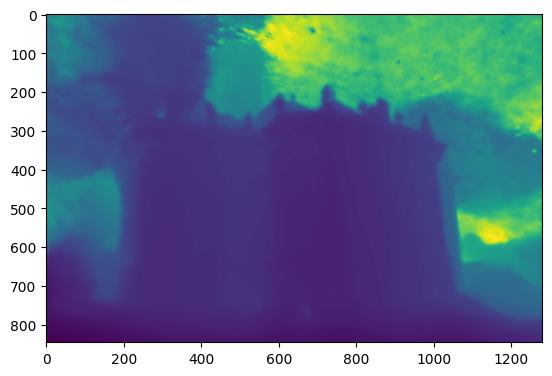

In [6]:
plt.imshow(outputs['prop_depth_1'].cpu().detach().numpy())

In [10]:
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)
model.icosphere_order = 1

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

num_rays_per_chunk = 2048
image_height, image_width = camera_ray_bundle.origins.shape[:2]
num_rays = len(camera_ray_bundle)
p2p_dist_list = []

for i in tqdm.tqdm(range(0, num_rays, num_rays_per_chunk)):
  start_idx = i
  end_idx = i + num_rays_per_chunk
  ray_bundle = camera_ray_bundle.get_row_major_sliced_ray_bundle(start_idx, end_idx)
  # forward through model for camera ray bundle
  ray_samples, weights_list, ray_samples_list = model.proposal_sampler(ray_bundle, density_fns=model.density_fns)

  illumination_field = model.illumination_field_train

  illumination_directions = model.illumination_sampler(model.config.num_illumination_samples)
  illumination_directions = illumination_directions.to(device)

  field_outputs = model.field(ray_samples, return_alphas=True, illumination_directions=illumination_directions)
  weights, transmittance = ray_samples.get_weights_and_transmittance_from_alphas(
      field_outputs[FieldHeadNames.ALPHA]
  )

  p2p_dist = model.renderer_depth(weights=weights, ray_samples=ray_samples)
  p2p_dist_list.append(p2p_dist.clone().detach())

p2p_dist = torch.cat(p2p_dist_list, dim=0)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 530/530 [00:22<00:00, 23.99it/s]


plotting the point to point distance shows the noise of using this to estimate termination point

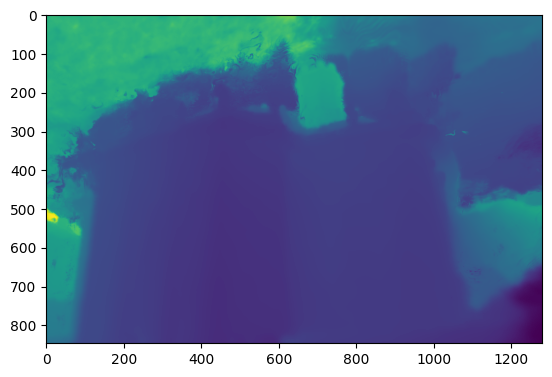

In [19]:
plt.imshow(p2p_dist.reshape(image_height, image_width).cpu().detach().numpy())

In [15]:
model.scene_box

SceneBox(aabb=tensor([[-1., -1., -1.],
        [ 1.,  1.,  1.]]), coarse_binary_gird=None, near=0.01, far=3.5, radius=1.0, collider_type='near_far')

In [ ]:
reni_field = RENIField(pipeline_config.model.reni_path, num_latent_codes=1673, fixed_decoder=False)
reni = reni_field.reni
reni.fixed_decoder = True

z = torch.load('checkpoints/reni_pretrained_weights/z_point_light.pt')
z = z.repeat(1673, 1, 1)
reni.mu.data = z

W = 512
H = W // 2
D = get_directions(W)

axis = [0, 1, 0]
angle = np.pi / 1 # 45 degrees
R = torch.tensor(rotation_matrix(axis, angle), dtype=torch.float32)
reni.mu.data = torch.matmul(reni.mu.data, R)

idx = 0
img = reni(idx, D)
img = img.reshape(H, W, 3)
img = img.permute(2, 0, 1) # to CHW
img = reni.unnormalise(img)
img = sRGB(img)[0]
plt.imshow(img.detach().cpu().numpy().transpose(1, 2, 0))

In [3]:
# Z = torch.load('checkpoints/reni_pretrained_weights/z_point_light.pt')
# Z = Z.repeat(model.num_eval_data, 1, 1).to(device)
# model.illumination_field_eval.reni.mu.data = Z
Z = model.illumination_field_train.reni.mu.data[0:1]
Z = Z.repeat(model.num_eval_data, 1, 1).to(device)
model.illumination_field_eval.reni.mu.data = Z

In [4]:
model.use_visibility = 'sphere_tracing'
model.icosphere_order = 11
camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
batch = make_batch_clone(batch_original)

camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

model.config.eval_num_rays_per_chunk = 5000

outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle, show_progress=True)

Generating output for camera... ━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━  67% 0:28:24

RuntimeError: CUDA out of memory. Tried to allocate 5.13 GiB (GPU 0; 44.40 GiB total capacity; 29.39 GiB already allocated; 5.10 GiB free; 37.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
plt.imshow(outputs['rgb'].cpu().detach().numpy())

In [ ]:
imgs = []
axis = [0, 1, 0]  # y-axis
for angle in tqdm.tqdm(range(0, 721, 10)):
    R = torch.tensor(rotation_matrix(axis, np.radians(angle)), dtype=torch.float32).to(device)
    model.illumination_field_eval.reni.mu.data = torch.matmul(Z, R)
    # get the current 
    camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
    batch = make_batch_clone(batch_original)

    camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

    camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

    model.config.eval_num_rays_per_chunk = 2048

    outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

    imgs.append(outputs['rgb'].cpu().detach().numpy())

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animate_images(images):
    """
    Create an animation of a sequence of images.
    """
    fig, ax = plt.subplots()
    im = ax.imshow(images[0])

    def update(frame):
        im.set_data(images[frame])
        return [im]

    anim = FuncAnimation(fig, update, frames=len(images), interval=100)
    plt.close(fig)
    return anim

anim.save('rotation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

In [ ]:
out

In [ ]:
model.use_visibility = 'sdf'

In [ ]:
imgs = []
axis = [0, 1, 0]  # y-axis
for angle in tqdm.tqdm(range(0, 361, 10)):
    R = torch.tensor(rotation_matrix(axis, np.radians(angle)), dtype=torch.float32).to(device)
    model.illumination_field_eval.reni.mu.data = torch.matmul(Z, R)
    # get the current 
    camera_ray_bundle = make_ray_bundle_copy(camera_ray_bundle_original)
    batch = make_batch_clone(batch_original)

    camera_ray_bundle.nears = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.near

    camera_ray_bundle.fars = torch.zeros_like(camera_ray_bundle.directions_norm) + model.scene_box.far

    model.config.eval_num_rays_per_chunk = 256

    outputs = model.get_outputs_for_camera_ray_bundle(camera_ray_bundle)

    imgs.append(outputs['rgb'].cpu().detach().numpy())

In [ ]:

import os
cwd = os.getcwd()

In [ ]:
cwd

In [ ]:
import torch

In [ ]:
import gc

def delete_all_variables():
    import gc
    for name in list(globals().keys()):
        if name not in {"delete_all_variables"}:
            del globals()[name]

    gc.collect()

# Call the function to delete all variables
delete_all_variables()